In [1]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_
%matplotlib notebook

The .h5 files to actually try spike sorting. 

In [2]:
filedirec = r"D:/Files_Reutlingen_Jenny/191021_hdf5/"
filename = "HCxA_Chr2_light_5000_100light_2000stop_position1.h5"


First problem is: We need a probe file, that takes the random configuration of channels of the MCS - MEA System into account. Let us first review the 'order' MCS channeles: 

In [3]:
channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirec, filename))


In [4]:
# find out, where our channel labels are hiding
channel_raw_data.recordings[0].analog_streams[0].channel_infos[1]
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]


Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 1500000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 1500000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">


In [5]:
ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,


Here is the channel_id

In [6]:
# here we find in the info part of channel infos all we search: info is a dictionary which
# has the 'Label' key
channel_raw_data.recordings[0].analog_streams[0].channel_infos[0].info


{'ChannelID': 0,
 'RowIndex': 0,
 'GroupID': 0,
 'ElectrodeGroup': 0,
 'Label': 'R12',
 'RawDataType': 'Int',
 'Unit': 'V',
 'Exponent': -12,
 'ADZero': 0,
 'Tick': 40,
 'ConversionFactor': 104166,
 'ADCBits': 16,
 'HighPassFilterType': '',
 'HighPassFilterCutOffFrequency': '-1',
 'HighPassFilterOrder': -1,
 'LowPassFilterType': '',
 'LowPassFilterCutOffFrequency': '-1',
 'LowPassFilterOrder': -1}

In [7]:
def get_label_dictionary_from_MCS_channel_infos(np_analog_for_filter, analog_stream_0):


    label_dictionary ={}

    for i in range(0, len(np_analog_for_filter)):
        channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[channel_idx]
        channel_info = analog_stream_0.channel_infos[channel_id]
        label_dictionary[channel_id]=channel_info.info['Label']
   
    return label_dictionary

Extracting infor from recording:



# MEA DATA

In [9]:
recording_MEA=se.MCSH5RecordingExtractor(os.path.join(filedirec+filename))

In [28]:
recording_f = st.preprocessing.bandpass_filter(recording_MEA, freq_min=150, freq_max=5000, filter_type='butter', order=2)
recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')


In [29]:
recording_MEA.get_channel_property_names(channel_id=0)

['group']

<IPython.core.display.Javascript object>


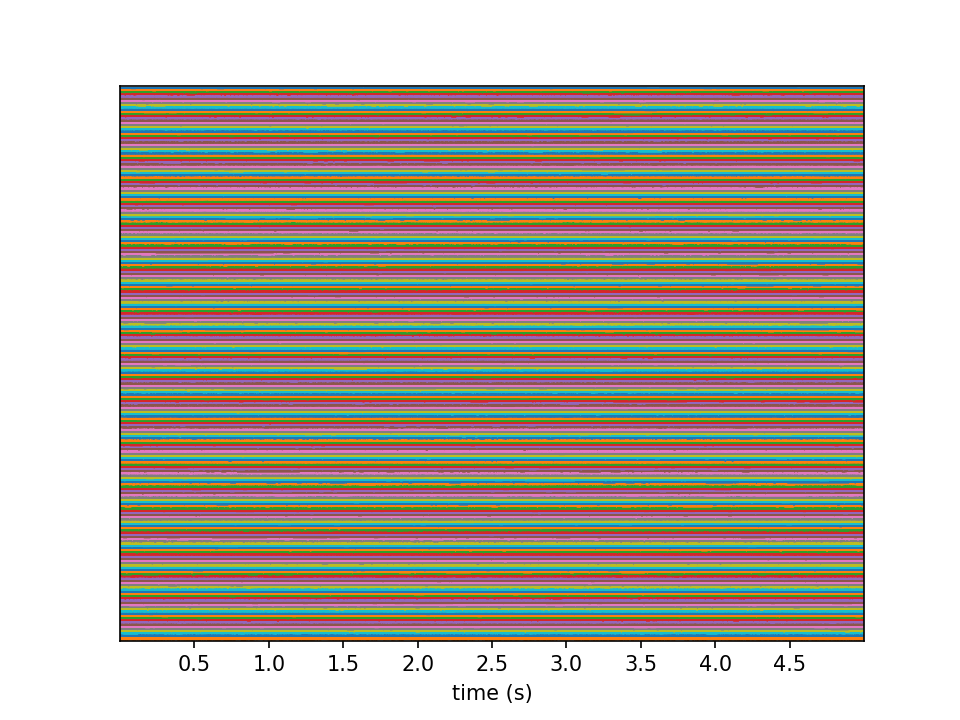

In [30]:
w_ts = sw.plot_timeseries(recording_cmr, trange=[0,5])
#w_rs = sw.plot_rasters(sorting_true, trange=[0,5])

In [31]:
print('Num. channels = {}'.format(len(recording_MEA.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording_MEA.get_sampling_frequency()))
print('Num. timepoints = {}'.format(recording_MEA.get_num_frames()))
print('Stdev. on third channel = {}'.format(np.std(recording_MEA.get_traces(channel_ids=2))))
print('Location of third electrode = {}'.format(recording_MEA.get_channel_property(channel_id=2, property_name='location')))

Num. channels = 252
Sampling frequency = 24999.999999999996 Hz
Num. timepoints = 1500000
Stdev. on third channel = 4.366326040234944e-06
Location of third electrode = [nan nan]


In [32]:
np.shape(recording_cmr.get_traces())

(252, 1500000)

In [33]:
recording_cmr.get_channel_property_names(channel_id=10)

['group']

In [34]:
recording_cmr.get_channel_locations()

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan,

In [35]:
recording_cmrprobe=recording_MEA.load_probe_file(probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb")

In [36]:
recording_cmrprobe.get_channel_property_names(channel_id=0)


['group', 'location']

In [37]:
recording_cmrprobe.get_channel_locations()

array([[3000.,  800.],
       [2000., 1200.],
       [2600., 1200.],
       [2800., 1000.],
       [2000., 1400.],
       [2400., 1400.],
       [2200., 1600.],
       [3000., 1600.],
       [2600., 2000.],
       [2400., 1800.],
       [3000., 2400.],
       [2800., 2200.],
       [3000., 2800.],
       [2200., 2200.],
       [1800., 2000.],
       [1600., 1600.],
       [2000., 2800.],
       [2200., 3000.],
       [1600., 2400.],
       [1800., 2600.],
       [1400., 3000.],
       [1600., 2000.],
       [1200., 2400.],
       [1400., 2200.],
       [ 800., 2800.],
       [1000., 2600.],
       [2400.,  600.],
       [2600.,  400.],
       [3000.,  600.],
       [2000., 1000.],
       [2600., 1000.],
       [2800.,  800.],
       [2200., 1400.],
       [2400., 1200.],
       [2000., 1600.],
       [3000., 1400.],
       [2600., 1800.],
       [2400., 1600.],
       [3000., 2200.],
       [2800., 2000.],
       [1800., 1800.],
       [2000., 1800.],
       [2400., 2400.],
       [260

<IPython.core.display.Javascript object>


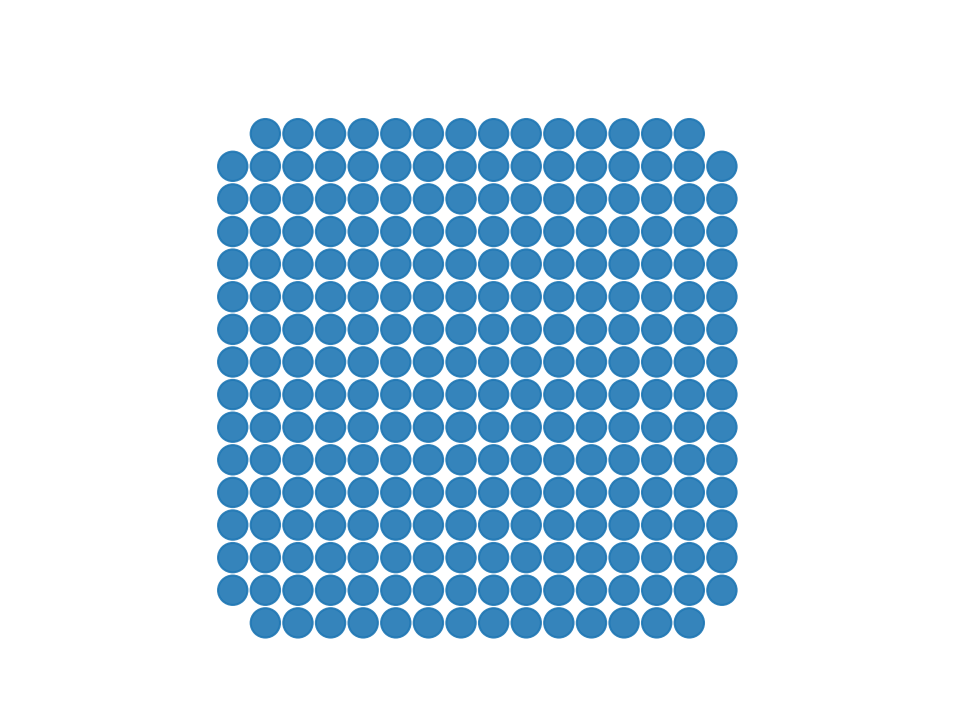

In [38]:
sw.plot_electrode_geometry(recording_cmrprobe, color='C0', label_color='r', figure=None, ax=None)

In [39]:
recording_cmrprobe.get_shared_channel_property_names()

['group', 'location']

In [40]:
probe_file="C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Spikesorting/MCS_MEA_256_100µM_spacing.prb"

In [41]:
outputdirectory='D:/Files_Reutlingen_Jenny/spikeinterfacetrial_170321'

In [43]:
ss.get_default_params("spykingcircus")

{'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': True,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [48]:
# SpyKING Circus spike sorting
sorting_SC = ss.run_spykingcircus(recording_cmrprobe, output_folder=outputdirectory)
sorting_curated = st.curation.threshold_num_spikes(sorting=sorting_SC, threshold=10, threshold_sign='less')
st.postprocessing.export_to_phy(recording=recording_cmrprobe, sorting=sorting_curated, output_folder=outputdirectory)


print('Units found with Spyking Circus:', sorting_SC.get_unit_ids())

RUNNING SHELL SCRIPT: D:\Files_Reutlingen_Jenny\spikeinterfacetrial_170321\run_spykingcircus.bat
You can run spiketoolkit.preprocessing.bandpass_filter(recording, cache_to_file=True)
Recomputing info
Units found with Spyking Circus: [0, 1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 13, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 14, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 15, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 16, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 17, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 19, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 2, 20, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 23, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 2

<IPython.core.display.Javascript object>


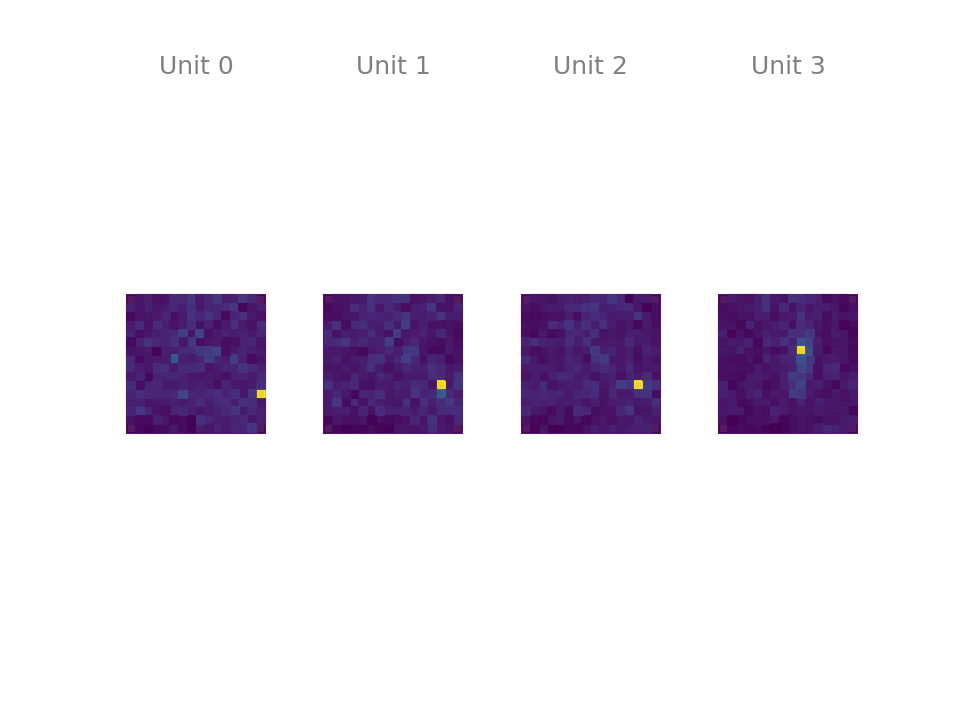

In [47]:
sw.plot_unit_template_maps(recording_MEAprobe,  sorting_SC, max_spikes_per_unit=100, unit_ids=[0,1,2,3])

<IPython.core.display.Javascript object>


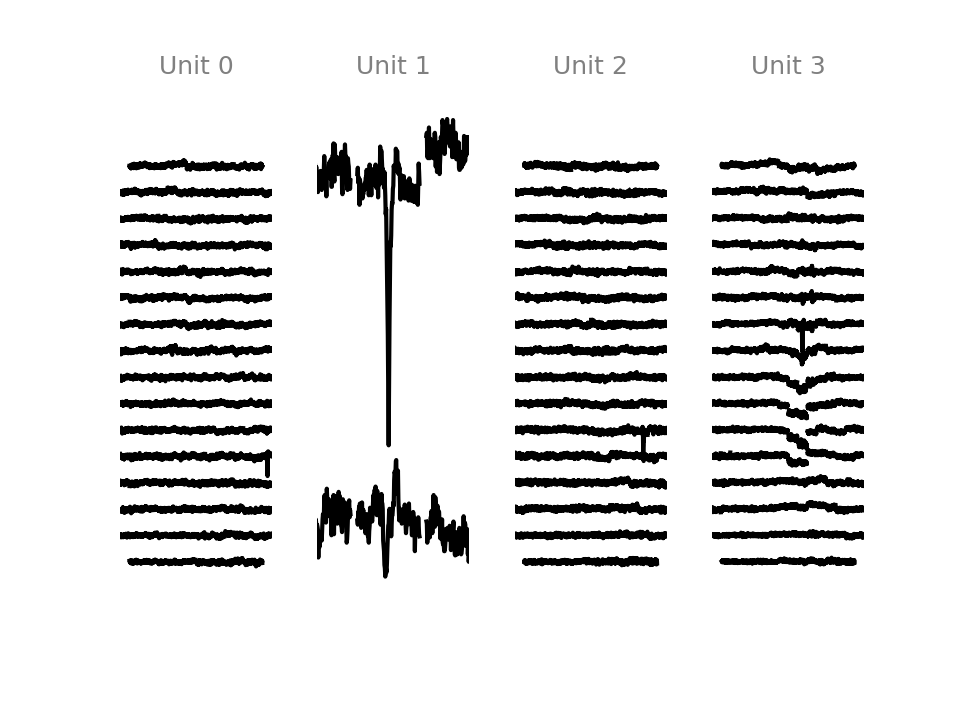

{'max_spikes_per_unit': 100}


In [64]:
sw.plot_unit_templates(recording_MEAprobe,  sorting_SC, max_spikes_per_unit=100, unit_ids=[0,1,2,3])

<IPython.core.display.Javascript object>


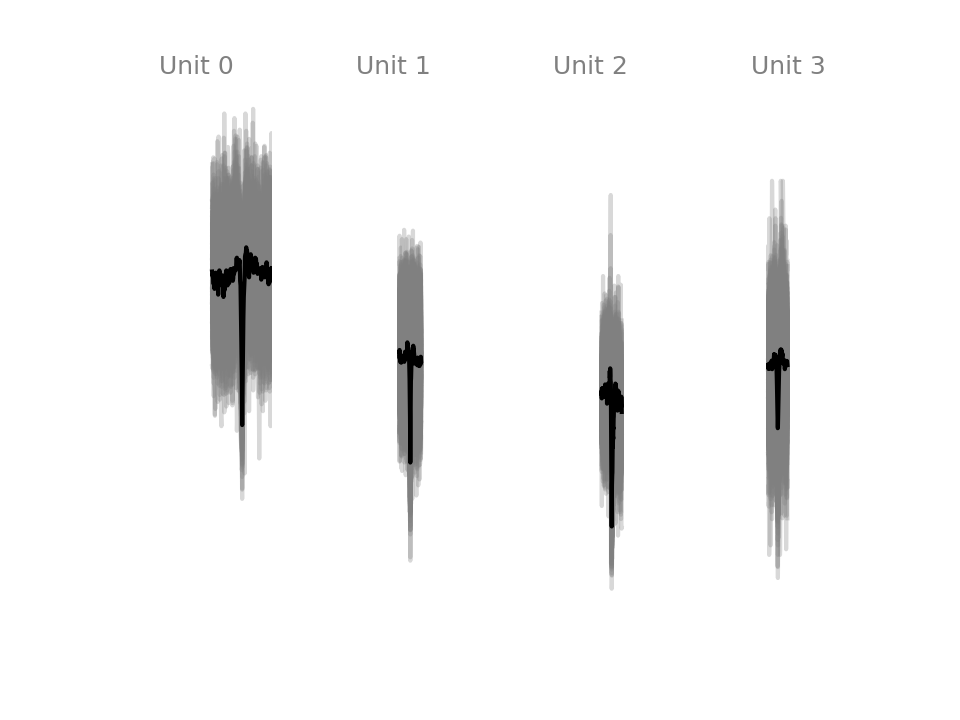

{}


In [58]:
sw.plot_unit_waveforms(recording=recording_MEAprobe, sorting=sorting_SC, unit_ids=[0,1,2,3], max_channels=1)

<IPython.core.display.Javascript object>


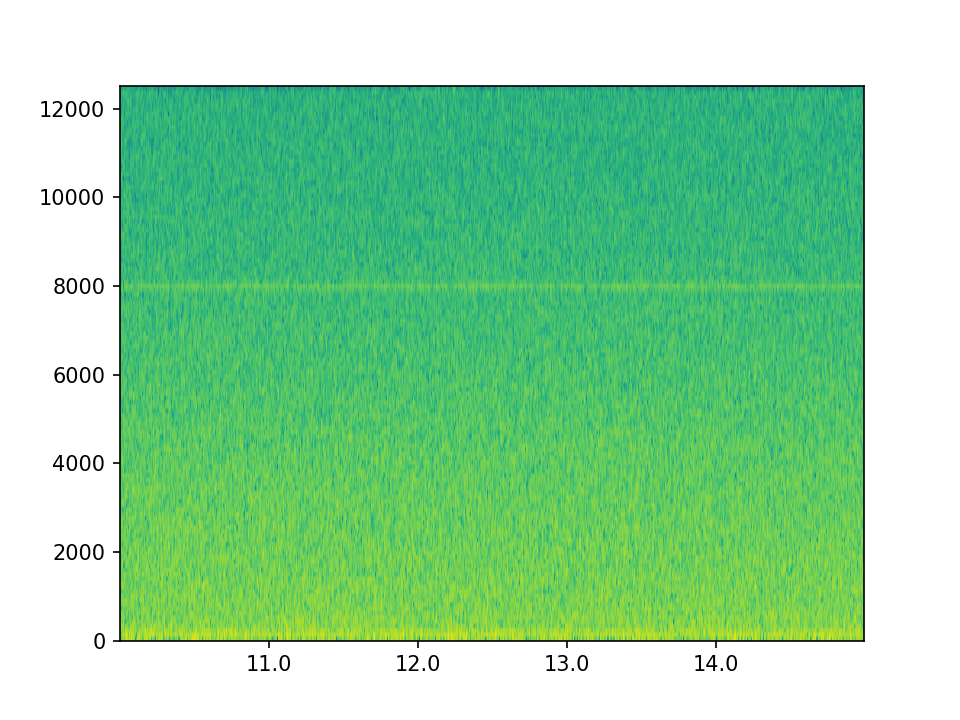

In [49]:
sw.plot_spectrogram(recording_MEAprobe, channel=0, trange=[10,15], freqrange=None, cmap='viridis', nfft=256, figure=None, ax=None)

<IPython.core.display.Javascript object>


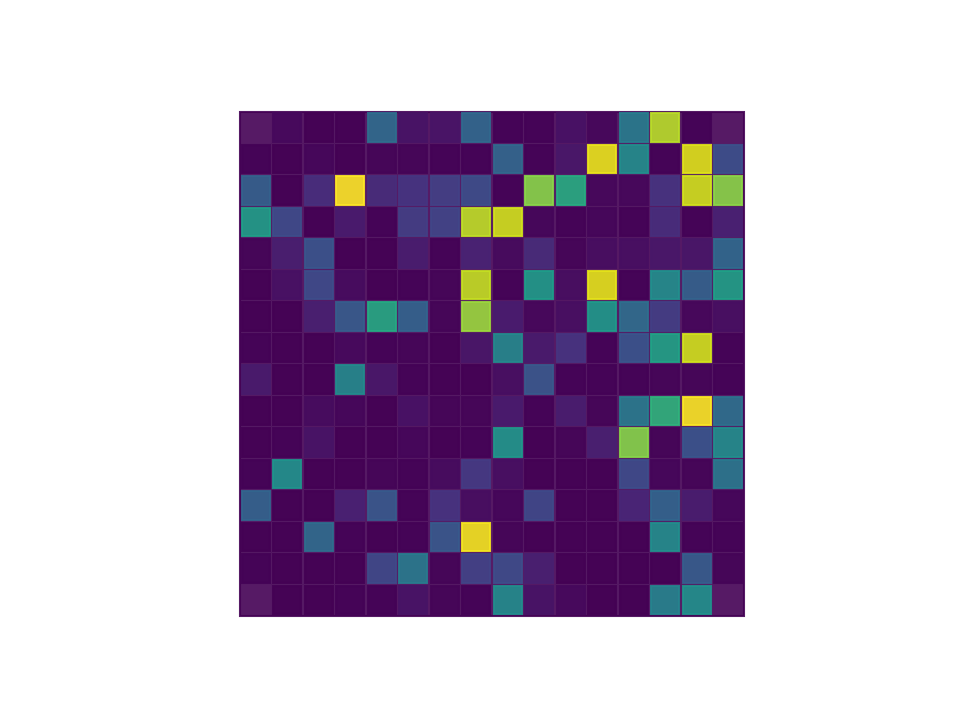

In [51]:
sw.plot_activity_map(recording_MEAprobe, log=True)

In [ ]:
isi_violations = st.validation.compute_isi_violations(sorting, duration_in_frames=recording.get_num_frames(), isi_threshold=0.0015)
snrs = st.validation.compute_snrs(recording=recording, sorting=sorting, max_spikes_per_unit_for_snr=1000)
nn_hit_rate, nn_miss_rate = st.validation.compute_nn_metrics(recording=recording, sorting=sorting, num_channels_to_compare=13)

# Validation of Spikesorting

In [66]:
ss.get_default_params('spykingcircus')

{'detect_sign': -1,
 'adjacency_radius': 100,
 'detect_threshold': 6,
 'template_width_ms': 3,
 'filter': True,
 'merge_spikes': True,
 'auto_merge': 0.75,
 'num_workers': None,
 'whitening_max_elts': 1000,
 'clustering_max_elts': 10000}

In [67]:
help(ss.run_spykingcircus)

Help on function run_spykingcircus in module spikesorters.sorterlist:

run_spykingcircus(*args, **kwargs)
    Runs spykingcircus sorter
    
    Parameters
    ----------
    *args: arguments of 'run_sorter'
        recording: RecordingExtractor
            The recording extractor to be spike sorted
        output_folder: str or Path
            Path to output folder
        delete_output_folder: bool
            If True, output folder is deleted (default False)
        grouping_property: str
            Splits spike sorting by 'grouping_property' (e.g. 'groups')
        parallel: bool
            If True and spike sorting is by 'grouping_property', spike sorting jobs are launched in parallel
        verbose: bool
            If True, output is verbose
        raise_error: bool
            If True, an error is raised if spike sorting fails (default). If False, the process continues and the error 
            is logged in the log file
        n_jobs: int
            Number of jobs when 

Next things:

- why are some channels empty? 
- How can we map that outcome?
- can I get spiketrains from this data?

In [68]:
import hdfviewer as hv

In [70]:
resultfile = "D:\Files_Reutlingen_Jenny\spikeinterfacetrial_080321\recording\recording.templates-merged.hdf5"